# Stitch COCO-Periph Images to Create Pseudofoveated

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def readin_imglist(imgnum, eccs = [0,5,10,15,20],filepath='./COCO_Periph'):
    '''
    Readin the uniform images at each of the eccentricities according to our filestructure

    Parameters:
        imgnum (str): the MS COCO Image number desired
        eccs (list of floats): the eccentricities in degrees desired
        filepath (str): path to the COCO Periph Directory
    Returns:
        imglist (list of numpy arrays): List of uniformly foveated images
    '''
    imglist = []
    for e in eccs:
        if(e==0):
            impath = os.path.join(filepath,f'ecc{e*16}',f'{imgnum.zfill(12)}.jpg')
        #   impath = os.path.join(filepath,'originals',f'{imgnum.zfill(12)}.jpg')
        else:
            impath = os.path.join(filepath,f'ecc{e*16}',f'mongrel_{imgnum.zfill(12)}_ecc_{e*16}_0.jpg')
            #impath = os.path.join(filepath,f'ecc{e}',f'{imgnum.zfill(12)}.jpg')

        print(impath)
        im = cv2.cvtColor(cv2.imread(impath), cv2.COLOR_BGR2RGB)
        imglist.append(im)
    return(imglist)

uniform_imgs = readin_imglist('11197',filepath='../COCO_Periph_CSHL_Demo/experiment_stimuli/')

../COCO_Periph_CSHL_Demo/experiment_stimuli/ecc0/000000011197.jpg
../COCO_Periph_CSHL_Demo/experiment_stimuli/ecc80/mongrel_000000011197_ecc_80_0.jpg
../COCO_Periph_CSHL_Demo/experiment_stimuli/ecc160/mongrel_000000011197_ecc_160_0.jpg
../COCO_Periph_CSHL_Demo/experiment_stimuli/ecc240/mongrel_000000011197_ecc_240_0.jpg
../COCO_Periph_CSHL_Demo/experiment_stimuli/ecc320/mongrel_000000011197_ecc_320_0.jpg


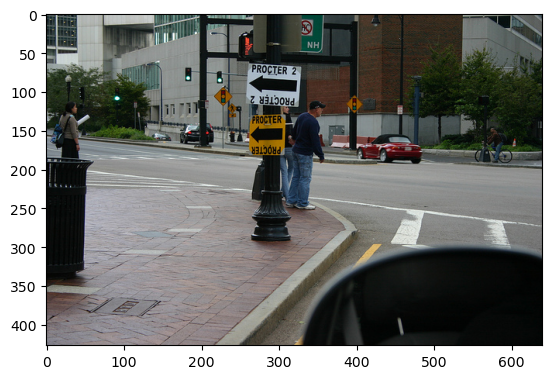

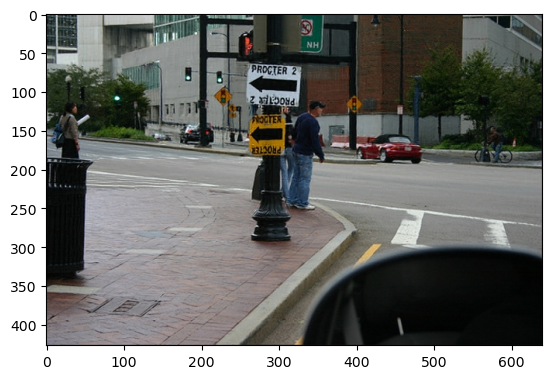

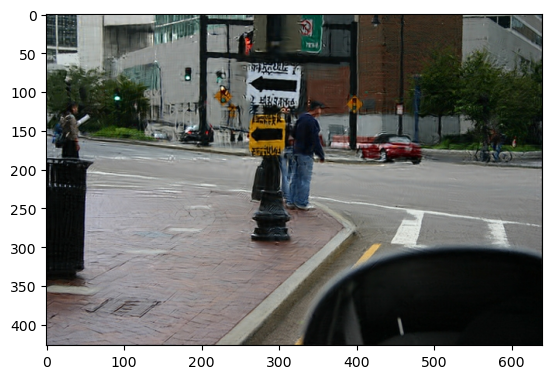

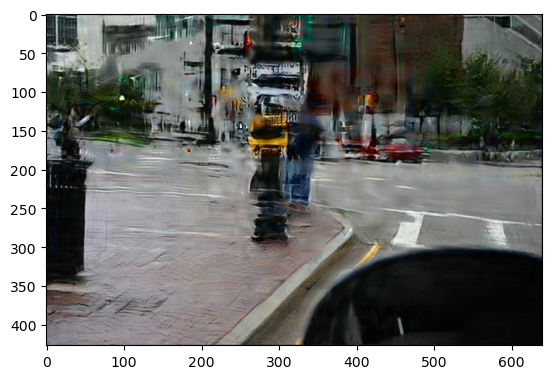

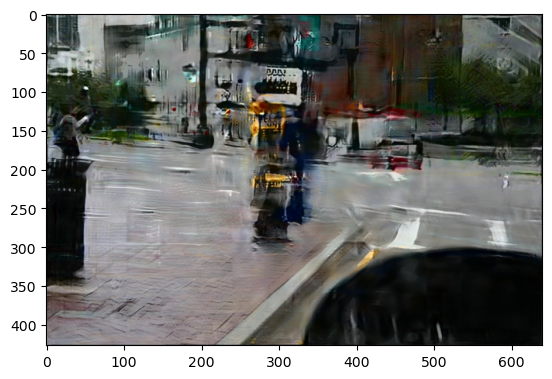

In [4]:
for im in uniform_imgs:
    plt.imshow(im)
    plt.show()

[0, 80, 160, 240, 320]
0 [0, 16]
()


ValueError: not enough values to unpack (expected 2, got 0)

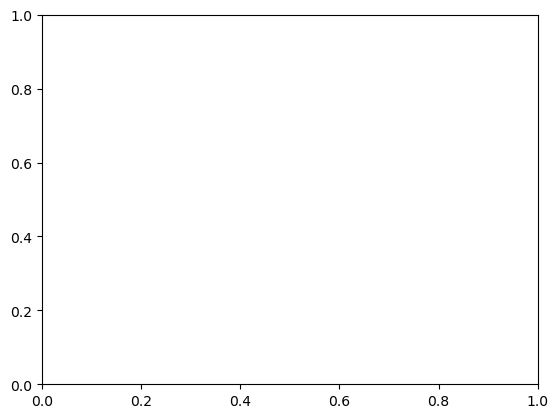

In [5]:
def stitch_image(uniform_imlist, fixation, deglist=[0,5,10,15,20], ppd=16, blend_radius = 5):
    '''
    Funtion to stitch together uniformly tiled coco-periph images to create a new
    transformed peripheral image representing progressive loss of information from
    the chosen fixation location

    Parameters:
        uniform_imlist (list of numpy arrays): list of uniform foveated images to be stitched, starting from 0 degrees to furthest
            *Note*: All images in imlist must be the same size, and should start with an original image, then uniform transforms.
        fixation (tuple): (x,y) fixation location specified in pixels
        deglist (list of floats or ints): list of eccentricities represented by each image in imlist.
            *Note*: imlist and deglist must be the same length, and start with zero and increase.
        ppd (int): how many pixels subtend 1 degree viewing angle? (This is calculated by viewing distance, and COCO-Periph uses 16ppd)
            *Note*: PPD also specifies the fovea size, or the radius of the original image in the center of fixation.
            *Note2*: Leave this at 16 if you are using COCO-Periph Images.
        blend_radius (int): How many pixels on each side of the stitching border between images do we blend with? This avoids circular borders.    

    Returns:
        pseudo_im (numpy array): Pseudofoveated Image
    
    '''
    #assume a 1 degree radius fovea
    fovea_size = ppd
    #convert degree list to pixel radius from center
    pixel_list = [ppd * d for d in deglist]
    print(pixel_list)
    
    #calcualte radius from fixation location
    fx_x, fx_y = fixation
    imsize_x, imsize_y, _ = np.shape(uniform_imlist[0])
    normalized = ((imsize_x-fx_x),(imsize_y-fx_y))
    r = np.hypot(normalized[0], normalized[1])

    #fill whole image with furthest eccentricity
    pseudo_im = uniform_imlist[-1]
    #loop through closer eccentricities and fill in donuts around the center
    for i, ecc in enumerate(deglist):
        #if this is fovea, should be a circle at the center of fixation.
        if(i==0):
            ecc_range = [0,fovea_size]
        #otherwise create rings around center
        else:
            #first image is a special case, start out from fovea, then go out to halfway between first and second boundary
            if(i==1):
                #offset puts the border halfway between limit of this eccentricity and next eccentricity up.
                ecc_offset_above = (pixel_list[2] - pixel_list[1])//2
                ecc_range = [fovea_size,pixel_list[i]+ecc_offset_above]
            #last image is also a special case because we have no border above.
            elif(i==len(deglist)-1):
                # We've seeded the pseudo_im with this image already, so don't need to do this, but do it for completeness.
                ecc_offset_below = (pixel_list[i] - pixel_list[i-1])//2 #this is the offset_above from the last loop
                #our range in pixels for this eccentricity is centered at this pixel eccentricity, and halfway above and below to the neighboring ecc. 
                ecc_range = [pixel_list[i]-ecc_offset_below,pixel_list[i]]
            #all others blend bidirectionally.
            else:
                #here we need the offset both above and below
                ecc_offset_above = (pixel_list[i+1] - pixel_list[i])//2
                ecc_offset_below = (pixel_list[i] - pixel_list[i-1])//2 #this is the offset_above from the last loop
                #our range in pixels for this eccentricity is centered at this pixel eccentricity, and halfway above and below to the neighboring ecc. 
                ecc_range = [pixel_list[i]-ecc_offset_below,pixel_list[i]+ecc_offset_above]
                print(ecc_offset_below, ecc_offset_above)
        print(ecc, ecc_range)
        
        #Now that we've specified the range, create a mask for a ring/doughnut at this eccentricity (plus the blending region)
        ecc_mask = np.where((r>=ecc_range[0]) & (r<ecc_range[1]+blend_radius),1., 0.).astype(np.float32)
        print(ecc_mask.shape)
        plt.pcolormesh(ecc_mask)
        plt.show()
        
        #gaussian blending to remove sharp edges
        # if(i>0):
        #     start_blend_r = ecc_range[0]-blend_radius
        #     end_blend_r = ecc_range[0]+blend_radius
        #     #     #mask must extend lower for linear blend
        #     ecc_mask = np.where((r>=start_blend_r) & (r<ecc_range[1]+blend_radius),1.,0.).astype(np.float32)
        #     ecc_mask = np.where((r>=start_blend_r) & (r<end_blend_r),(r-start_blend_r)/(end_blend_r-start_blend_r),ecc_mask)

        ecc_mask_3d = np.concatenate((ecc_mask[:,:,None],ecc_mask[:,:,None],ecc_mask[:,:,None]),2)

        invert_mask = 1.0-ecc_mask_3d

        plt.imshow(ecc_mask_3d[:,:,0])
        plt.colorbar()
        plt.show()
        plt.imshow(invert_mask[:,:,0])
        plt.colorbar()
        plt.show()


    
        # #for eccentricities other than zero, use the mask at this eccentricity and add it to the final foveatd image.
#plt.imshow(ecc_mask_3d[:,:,0])
                    #plt.colorbar()
                    #plt.show()
                    #plt.imshow(invert_mask[:,:,0])
                    #plt.colorbar()
                    #plt.show()
        # pseudo_im = np.uint8(ecc_mask_3d * unif_mong_list[i] + invert_mask * pseudo_im)
    return(pseudo_im)

stitched_image = stitch_image(uniform_imgs, (50,50))

In [ ]:
#calcuate in native 16ppd
import os
fovea_size = ppd = 16
save_folder = './psychophysics_experiment/stimuli/pseudofoveated/absent/'

os.makedirs("./psychophysics_experiment/stimuli/pseudofoveated/absent/80",exist_ok=True)
os.makedirs("./psychophysics_experiment/stimuli/pseudofoveated/absent/160",exist_ok=True)
os.makedirs("./psychophysics_experiment/stimuli/pseudofoveated/absent/240",exist_ok=True)
os.makedirs("./psychophysics_experiment/stimuli/pseudofoveated/absent/320",exist_ok=True)
obj_eccs = [80,160,240,320]

for imname in bbx_list['image_name']:
    imnum = imname.replace('.jpg','')
    if imnum in stim_list:
        for seed in range(10):
            #readin eccentricity mongrels
        #    im_fov,im_80,im_160,im_240,im_320 = readin_eccs(imname)
            unif_mong_list = readin_eccs(imname,seed=seed,present=False)
            #calculate pixel radius
            img_shape = np.shape(unif_mong_list[0])
            y, x = np.indices([img_shape[0], img_shape[1]])
            num_bins = np.min([img_shape[0], img_shape[1]])
            #loop through fixation eccentricities
            for fx_ecc in obj_eccs[:]:
                #get fixation location
                deg_ecc = fx_ecc//ppd
                fx_x = bbx_list.loc[bbx_list['image_name'] == imname, f'fx_x_{ppd}_{deg_ecc}'].item()
                fx_y = bbx_list.loc[bbx_list['image_name'] == imname, f'fx_y_{ppd}_{deg_ecc}'].item()
                #calcualte radius from fixation location
                normalized = ((x-fx_x),(y-fx_y))
                r = np.hypot(normalized[0], normalized[1])
                #loop through image eccentricity rings
                ecc_offset = 40 #halfway in between each eccentricity
                ecc_ranges = [[0,fovea_size], #fovea
                              [fovea_size,obj_eccs[0]+ecc_offset], #80
                              [obj_eccs[1]-ecc_offset,obj_eccs[1]+ecc_offset], #160
                              [obj_eccs[2]-ecc_offset,obj_eccs[2]+ecc_offset], #240
                              [obj_eccs[3]-ecc_offset,obj_eccs[3]+ecc_offset],] #320
                              # [obj_eccs[4]-ecc_offset,obj_eccs[4]+ecc_offset]] #320
                #fill image rings in
                blend_radius = 5 #blend for 5 pixels above and below 
                # foveated_mong = np.zeros_like((unif_mong_list[0]))
                # changed to use the last mongrel as a base to get rid of black ring
                foveated_mong = unif_mong_list[-1]
                for i, ecc_range in enumerate(ecc_ranges):
                    #non-lienar-blended mask
                    #ecc_mask = np.where((r>=ecc_range[0]) & (r<ecc_range[1]),1., 0.).astype(np.float32)
                    #last eccentricity goes only up to edge, no blending
                    #if(i==len(ecc_ranges)-1):
                    #ecc_mask = np.where((r>=ecc_range[0]) & (r<ecc_range[1]),1., 0.).astype(np.float32)
                    #else:
                    ecc_mask = np.where((r>=ecc_range[0]) & (r<ecc_range[1]+blend_radius),1., 0.).astype(np.float32)
                    #plt.imshow(ecc_mask)
                    #plt.colorbar()
                    #plt.show()
                    #linear blend below
                    if(i>0):
                        start_blend_r = ecc_range[0]-blend_radius
                        end_blend_r = ecc_range[0]+blend_radius
                        #mask must extend lower for linear blend
                        ecc_mask = np.where((r>=start_blend_r) & (r<ecc_range[1]+blend_radius),1.,0.).astype(np.float32)
                        ecc_mask = np.where((r>=start_blend_r) & (r<end_blend_r),(r-start_blend_r)/(end_blend_r-start_blend_r),ecc_mask)

                    #ecc_mask = np.where((r>=ecc_range[0])(r<ecc_range[1]),True, False) == True
                    ecc_mask_3d = np.concatenate((ecc_mask[:,:,None],ecc_mask[:,:,None],ecc_mask[:,:,None]),2)

                    invert_mask = 1.0-ecc_mask_3d

                    #plt.imshow(ecc_mask_3d[:,:,0])
                    #plt.colorbar()
                    #plt.show()
                    #plt.imshow(invert_mask[:,:,0])
                    #plt.colorbar()
                    #plt.show()
                    foveated_mong = np.uint8(ecc_mask_3d * unif_mong_list[i] + invert_mask * foveated_mong)
                    #foveated_mong = np.where(ecc_mask_3d, unif_mong_list[i],foveated_mong)
                    #foveatd_mong = cv2.bitwise_and(foveated_mong,unif_mong_list[i],ecc_mask)

                    #foveated_mong[ecc_mask] = unif_mong_list[i][ecc_mask]
                #blend at edges
                #for i, ecc_range in ecc_ranges:
                    #blend_mask = np.where((r>ecc_range[1]-blend_radius) & (ecc_range[1]+blend_radius),r/,0.)
                    #blend_mask_3d = np.concatenate((blend_mask[:,:,None],blend_mask[:,:,None],blend_mask[:,:,None]),2)*255

                    #plt.imshow(r)
                    #plt.show()
                # plt.imshow(foveated_mong)
                # plt.scatter(fx_x,fx_y)
                # plt.title(imname)
                # plt.show()

                foveated_mong_cv2 = cv2.cvtColor(foveated_mong, cv2.COLOR_RGB2BGR) 
                cv2.imwrite(f'{save_folder}/{fx_ecc}/{imnum}_{seed}.png',foveated_mong_cv2)

